In [194]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime

"""
Récupération des rendements des actifs du DJIA
""" 

def get_rendements(stocks,début,fin): #date=yyyy-mm-dd en string
    prix=pdr.get_data_yahoo(stocks,start=début,end=fin)['Close'] 
    returns=prix.pct_change()
    logrdt=np.log(1+returns)*100
    logrdt=logrdt.iloc[1:]
    returns=returns.iloc[1:]
    prix=prix.iloc[1:]
    return  returns, prix, logrdt

stocks=stocks=['AAPL','AXP','BA', 'CAT', 'CSCO', 'CVX','DD','DIS','GE','HD','HPQ','IBM','INTC','JNJ','JPM','KO','MCD','MMM','MRK','MSFT','NKE','PFE','PG','RTX','T','TRV','UNH','VZ','WMT','XOM']
début='1995-12-29'
fin='2014-12-31'

output=get_rendements(stocks, début, fin)
rendements=output[0]
prix=output[1]
rdt_log=output[2]

C:\Users\baptc\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [83]:
import numpy as np
import numpy.random as npr
from scipy.optimize import minimize



def fonction_optimisation(Beta):
    """
    Fonction de perte aymétrique et par morceaux de Giacomini et Komunjer (2005)
    """ 
    
    Rendement=npr.randn(100,1)
    prevision=npr.randn(100,2)
    
    Beta0=np.ones((100,1))

    Prevision=np.concatenate((Beta0,prevision),axis=1)
    T=Rendement.shape[0]

    alpha=0.01
    
    Loss=0
    for i in range(0,T):
        
        u=(Rendement[i]-Prevision[i,:].dot(Beta))
        
        if u<=0:
            y=1
            Loss=Loss+((alpha-y)*u)  
        else:
            y=0

         
    return Loss



In [195]:
import numpy as np
from scipy.stats import norm

def VaR_Weighted_HS(rdt,sample_size=250,var_quantile=0.01):
    """
    Weighted historical simulation
    """
    
    # Récupération des rendements
    rendement=rdt.values
    # Création de la matrice des poids
    weights=np.zeros(250)
    
    # Attribution des poids (poids les plus récents > poids plus important)
    for i in range(1,251,1):
        weights[250-i]=(0.99**(i-1)*(1-0.99))/(1-(0.99**250))
    # Calcul des rendements pondérs
    sample=np.multiply(rendement,weights)
    

    # Calcul de la moyenne
    mu=np.sum(sample)
    # Calcul de l'écart-type
    rendement_c=rendement-np.mean(mu)
    rendement_c2=rendement_c**2
    samplec=np.multiply(rendement_c2,weights)
    sigma=np.sum(samplec)
    sigma=np.sqrt(sigma)
    # on réalise une simulation de paramètres mu et sigma
    # on pondère les rendements en accordant un poids plus
    # important aux rendements les plus récents
    sample2=norm.rvs(loc=mu,scale=sigma, size=sample_size)
    sample2=np.sort(sample2)
    
    # Calcul de la VaR 
    VaR=sample2[int(sample_size*var_quantile)-2]
    

    
    
 
    return VaR



In [196]:
import numpy as np

VaR_Weighted_HS_Asset=np.zeros((len(rdt_log),30))


for j in range(0,30):
    for i in range(250,len(rdt_log)):
        VaR_Weighted_HS_Asset[i,j]=VaR_Weighted_HS(rdt_log.iloc[i-250:i,j],250,var_quantile=0.01)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [186]:
from pandas import*

VaR_Weighted_HS_Asset_Resultat=DataFrame(VaR_Weighted_HS_Asset[2770:,:],index=rdt_log.index[2770:])

In [176]:


# Fonction qui calcule le pourcentage de fois ou un rendement a été inférieur à la VAR
# La fonction crée 3 graphiques pour les trois périodes
# Les inputs sont des data frame : var_1 correspond aux VAR forecast de la 1ère période
# rdt_log_1 correspond aux rendements de la période 1
# même principe pour le reste 
# name correspond au nom de la méthode utilisé
def kupiec(var_1,rdt_log_1,var_2,rdt_log_2,var_3,rdt_log_3,name):
    
    '''c'est la partie 1 du graphique'''
    var=var_1
    rdt_log=rdt_log_1
    
    resu=[]
    p_un=rdt_log.shape[0]
    for j in range(0,len(rdt_log.columns)): #on s'interesse à tous les actifs
        rdt_logs=rdt_log.iloc[:,j]
        var_s=var.iloc[:,j]
        a=0
        for i in range(0,p_un):
            varr=var_s.iloc[i]
            rdt=rdt_logs.iloc[i]

            g_rdt=float(rdt)
            g_var=float(varr)
            #pour savoir si la Var a joué son rôle ou pas
            if g_var>g_rdt:
                a=a+1

        final=a/p_un
        resu.append(final)
    
    val=resu
    
    values=np.ones(len(rdt_log.columns))*0.005 #ici c'est pour tous les actifs
    plt.figure(figsize=(10, 0.5))
    un=plt.subplot(1,3,1)
    plt.scatter(val, values, s=20)
    plt.xticks([0.01,0.02,0.03])
    plt.yticks([])
    plt.xlim(0, 0.04)
    plt.ylim(0, 0.01)
    plt.axvline(x=0.01-2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01+2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01,color='grey')
    plt.title('période du 03.01.2007 au 31.12.2014',fontsize=8)
    plt.ylabel(name, fontsize=8)
    
    '''c'est la partie 2 du graphique'''
    #c'est quasiement le même code que pour la première partie du graphique
    var=var_2
    rdt_log=rdt_log_2
    
    resu=[]
    p_un=rdt_log.shape[0]
    for j in range(0,len(rdt_log.columns)): 
        rdt_logs=rdt_log.iloc[:,j]
        
        var_s=var.iloc[:,j]
        a=0
        for i in range(0,p_un):
            varr=var_s.iloc[i]
            rdt=rdt_logs.iloc[i]

            g_rdt=float(rdt)
            g_var=float(varr)
            
            if g_var>g_rdt:
                a=a+1

        final=a/p_un
        resu.append(final)
    val=resu
    values=np.ones(len(rdt_log.columns))*0.005 


    deux=plt.subplot(1,3,2)
    plt.scatter(val, values, s=20)
    plt.xticks([0.01,0.02,0.03])
    plt.yticks([])
    plt.xlim(0, 0.04)
    plt.ylim(0, 0.01)
    plt.axvline(x=0.01-2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01+2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01,color='grey')
    plt.title('période du 03.01.2007 au 31.12.2010',fontsize=8)
    
    
    var=var_3
    rdt_log=rdt_log_3
    
    resu=[]
    p_un=rdt_log.shape[0]
    for j in range(0,len(rdt_log.columns)): 
        rdt_logs=rdt_log.iloc[:,j]
        
        var_s=var.iloc[:,j]
        a=0
        for i in range(0,p_un):
            varr=var_s.iloc[i]
            rdt=rdt_logs.iloc[i]

            g_rdt=float(rdt)
            g_var=float(varr)
            
            if g_var>g_rdt:
                a=a+1
        final=a/p_un
        resu.append(final)
    val=resu
    
    
    '''c'est la partie 3 du graphique'''
    values=np.ones(len(rdt_log.columns))*0.005 

    trois=plt.subplot(1,3,3)
    plt.scatter(val, values, s=20)
    plt.xticks([0.01,0.02,0.03])
    plt.yticks([])
    plt.xlim(0, 0.04)
    plt.ylim(0, 0.01)
    plt.axvline(x=0.01-2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01+2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01,color='grey')
    plt.title('période du 03.01.2011 au 31.12.2014',fontsize=8)

    
    plt.show()
    


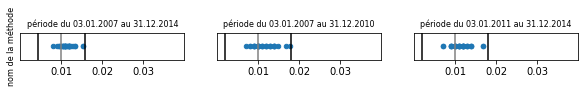

In [187]:
kupiec(VaR_Weighted_HS_Asset_Resultat,rdt_log.iloc[2770:,:],VaR_Weighted_HS_Asset_Resultat.iloc[0:1008,:],rdt_log.iloc[2770:3778,:],VaR_Weighted_HS_Asset_Resultat.iloc[1009:,:],rdt_log.iloc[3779:,:],"nom de la méthode")

In [197]:
VaR_Weighted_HS_Asset_Resultat_2000=DataFrame(VaR_Weighted_HS_Asset[1011:,:],index=rdt_log.index[1011:],columns=stocks)
VaR_Weighted_HS_Asset_Resultat_2000.to_csv("Weighted Historical Simulation Results 2000.csv")